### To run the cbgt network, see first the technical_testbench to install all the required packages and start the server 

In [1]:
#Auto reloading 
# %load_ext autoreload


# %autoreload
# %reload_ext autoreload 

In [2]:
#Removing indentation issues:
#!autopep8 --in-place --aggressive --aggressive init_params.py
#!autopep8 --in-place --aggressive --aggressive popconstruct.py
#!autopep8 --in-place --aggressive --aggressive generateepochs.py
#!autopep8 --in-place --aggressive --aggressive qvalues.py

# Compile the main simulator code using cython 

In [3]:
!python setup.py build_ext --inplace

running build_ext
running build_ext


# Import all the relevant files 

In [43]:
# Import the pipeline creation object
import pandas as pd
import numpy as np
import cbgt as cbgt
import pipeline_creation as pl_creat
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help


import importlib

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

<module 'postprocessing_helpers' from '/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py'>

# Choose the experiment and create the main pipeline

In [5]:
# Choose the experiment
experiment_choice = "n-choice"
number_of_choices = 2
# Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

# how many simulations do you want to run ? each simulation is executed as a seperate thread

num_sims = 1

num_cores = 7
# set a seed
import time
np.random.seed(int(time.time()))
#seed = np.random.choice(np.random.randint(0,9999999,100),1)[0]
seed = 8867366
print(seed)


in choose pipeline
in reward pipeline
8867366


In [6]:

# Define the data and figure directory

data_dir = "./Data/"
figure_dir = "./Figures/"


# Running the pipeline

### 1. Default values of environment variable

In [7]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None, # default = 600ms
    'thalamic_threshold': None, # default 30sp/s
    'movement_time':None,# #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout':None, #wait for a choice to be made, default 1000, 
    'params': None, #neuron parameters (init_params.py)
    'pops': None,   #population parameters (init_params.py)
    'receps' : None, #receptor parameters (init_params.py)
    'base' : None, #baseline stimulation parameters (init_params.py)
    'dpmns' : None, #dopamine related parameters (init_params.py)
    #'dpmns' : pd.DataFrame([0.05], columns=['dpmn_wmax']),
    #'d1' : None, #D1-MSNs population related parameters (init_params.py)
    'd1': None,#pd.DataFrame([[39.5,0.055]], columns=['dpmn_alphaw','dpmn_wmax']),
    'd2': None, #pd.DataFrame([[-38.2,0.035]], columns=['dpmn_alphaw','dpmn_wmax']),
        'channels' : pd.DataFrame([["left"],["right"]], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' :None,
    'Q_support_params': None,#pd.DataFrame([[85,0.6]],columns=['dpmn_CPP_scale','q_alpha']), #initialization of Q-values update (qvalues.py) 
    'Q_df_set':pd.DataFrame([[0.5, 0.5]],columns=["left","right"]), #initialized Q-values df (qvalues.py)  
    'n_trials': 3, #number of trials (generateepochs.py)
    'volatility': [2,"exact"], #frequency of changepoints and type of change points (exact or poisson) (generateepochs.py)
    'conflict': (0.7, 0.3), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.01, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # 3 instead? how much stimulus the LIP gets at maximum
    'corticostriatal_plasticity_present':True, # whether plasticity is on or "off" at corticostriatal synapses
    'record_variables':["weight","optogenetic_input"],#"optogenetic_input"],
    'opt_signal_present':[True],
    'opt_signal_probability':[[1]], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude':[-0.5], # ampitude of the stop signal over base line
    'opt_signal_onset':[10.], # in ms
    'opt_signal_duration':["phase 0"],
    'opt_signal_channel': ["all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["dSPN"],
    'sustainedfraction':0.7
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}


### Run the simulation - 1 thread with the environment variable

In [8]:
# pl.modulelist

In [9]:
results = cbgt.ExecutionManager(cores=num_cores).run([pl]*num_sims,[configuration]*num_sims)


(worker pid=None) in choose pipeline
SpawnThreadManagers <backend.Pipeline object at 0x7f1c8c232340>
(worker pid=None) in choose pipeline
(worker pid=None) change points: [0 2 2]
(worker pid=None) conflict (0.7, 0.3)
(worker pid=None) conflict (0.7, 0.3)
(worker pid=None) sum 1.0
(worker pid=None) n_prob_trials [1, 0]
(worker pid=None) calc_rew        left  right
(worker pid=None) 0  0.000000    0.0
(worker pid=None) 1  0.998486    0.0
(worker pid=None) reward_list        left  right
(worker pid=None) 0  0.000000    0.0
(worker pid=None) 1  0.998486    0.0
(worker pid=None) change points: [0 2 2]
(worker pid=None) conflict (0.7, 0.3)
(worker pid=None) conflict (0.7, 0.3)
(worker pid=None) sum 1.0
(worker pid=None) n_prob_trials [1, 0]
(worker pid=None) calc_rew        left  right
(worker pid=None) 0  0.000000    0.0
(worker pid=None) 1  0.998486    0.0
(worker pid=None) reward_list        left  right
(worker pid=None) 0  0.000000    0.0
(worker pid=None) 1  0.998486    0.0
SpawnThreadM

(worker pid=None) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=None)   Q_df = Q_df.append(
(worker pid=None) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=None)   Q_df = Q_df.append(
(worker pid=None) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=None)   Q_df = Q_df.append(
(worker pid=None) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=None)   Q_df = Q_df.append(


(worker pid=None) agent.opt_popids [array([6, 7])]
(worker pid=None) agent.opt_popids [array([6, 7])]
(worker pid=None) phasetimer 1001
(worker pid=None) gateFRs [11.11111111 14.88888889]
(worker pid=None) thresholds_crossed []
(worker pid=None) phasetimer 1001
(worker pid=None) gateFRs [11.11111111 14.88888889]
(worker pid=None) thresholds_crossed []
(worker pid=None) trial_num 0
(worker pid=None) chosen_action none
(worker pid=None) scaled dopamine signal 0.0`
(worker pid=None) trial_num 0
(worker pid=None) chosen_action none
(worker pid=None) scaled dopamine signal 0.0`
(worker pid=None) phasetimer 1001
(worker pid=None) gateFRs [12.          9.55555556]
(worker pid=None) thresholds_crossed []
(worker pid=None) phasetimer 1001
(worker pid=None) gateFRs [12.          9.55555556]
(worker pid=None) thresholds_crossed []
(worker pid=None) trial_num 1
(worker pid=None) chosen_action none
(worker pid=None) scaled dopamine signal 0
(worker pid=None) trial_num 1
(worker pid=None) chosen_act

In [15]:
# List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'corticostriatal_plasticity_present', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'sustainedfraction', 'par', 'popconstruct', 'interface', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'opt_df', 'opt_channels_dfs', 'opt_amplitude_dfs', 'opt_onset_dfs', 'opt_duration_dfs', 'opt_populations_df

In [16]:
results[0]['meaneff_GABA']

,GPi,GPi,STN,STN,GPe,GPe,dSPN,dSPN,iSPN,iSPN,Cx,Cx,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.058`,0.0`,0.35`,0.0`,1.75`,1.75`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.0`,0.058`,0.0`,0.35`,1.75`,1.75`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,2.09`,0.0`,0.0`,0.0`,0.0`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,0.0`,2.09`,0.0`,0.0`,0.0`,0.0`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
iSPN,0.0`,0.0`,0.0`,0.0`,4.07`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
iSPN,0.0`,0.0`,0.0`,0.0`,0.0`,4.07`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [17]:
results[0]['conflict']

(0.7, 0.3)

In [18]:
results[0]['Q_df']

,left,right
0,0.5,0.5
0,0.5,0.5
0,0.5,0.5
0,0.5,0.5


In [19]:
experiment_choice

'n-choice'

In [20]:
#Extract all the relevant dataframes
firing_rates, reward_q_df, performance, rt_dist, total_performance = plt_help.extract_relevant_frames(results,seed,experiment_choice)

/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = Q_df_local.append(rew_df)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(chosen_action)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(block)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append({'%_rewarded_actio

In [21]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPe_left,GPe_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,67.333333,67.111111,24.800000,25.377778,62.133333,57.711111,3.555556,3.333333,4.888889,6.222222,0.000000,0.000000,6.444444,6.000000,7.777778,0.627240,0
1,67.333333,68.444444,24.622222,25.288889,61.466667,57.177778,4.000000,3.111111,5.333333,6.222222,0.000000,0.000000,6.666667,5.777778,7.555556,0.627240,1
2,67.555556,68.888889,24.866667,25.288889,61.044444,57.422222,4.000000,3.111111,5.333333,6.000000,0.000000,0.000000,6.444444,5.777778,7.333333,0.627240,2
3,68.666667,69.555556,25.088889,25.444444,60.822222,57.622222,4.000000,3.111111,5.333333,6.222222,0.000000,0.000000,6.444444,5.555556,7.555556,0.627240,3
4,68.000000,70.222222,25.044444,25.511111,60.800000,57.555556,4.000000,3.111111,5.333333,6.222222,0.000000,0.000000,6.666667,5.555556,7.555556,0.627240,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,64.444444,70.888889,24.622222,26.177778,64.177778,58.844444,3.333333,4.000000,3.333333,5.111111,0.408497,0.816993,7.555556,5.333333,8.444444,1.523297,5560
5561,64.000000,70.222222,24.288889,26.022222,63.844444,58.822222,3.111111,4.000000,3.333333,5.111111,0.408497,0.816993,7.777778,5.111111,8.444444,1.433692,5561
5562,64.222222,68.000000,24.088889,26.000000,63.977778,59.088889,3.111111,3.777778,3.555556,5.333333,0.408497,0.816993,8.000000,5.555556,8.444444,1.433692,5562
5563,64.888889,68.222222,23.911111,26.133333,63.422222,59.200000,3.555556,3.777778,3.777778,5.333333,0.408497,0.816993,7.555556,5.555556,8.666667,1.344086,5563


In [22]:
# firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed,n_trials,volatility,volatility_type,conflict
0,0,GPi_left,67.333333,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
1,1,GPi_left,67.333333,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
2,2,GPi_left,67.555556,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
3,3,GPi_left,68.666667,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
4,4,GPi_left,68.000000,GPi,left,8867366_0,3.0,2,exact,"(0.7, 0.3)"
...,...,...,...,...,...,...,...,...,...,...
89035,5560,CxI_common,1.523297,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
89036,5561,CxI_common,1.433692,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
89037,5562,CxI_common,1.433692,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"
89038,5563,CxI_common,1.344086,CxI,common,8867366_0,3.0,2,exact,"(0.7, 0.3)"


In [23]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,66.666667,none,left,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,33.333333,none,right,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [24]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['left' 'right']
nuc_list ['dSPN-left' 'iSPN-left' 'dSPN-right' 'iSPN-right']
ind_list [[0 0 1 0]
 [0 1 1 1]]


/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)
/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)


In [25]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.015,0,dSPN-left,8867366_0
1,0.015,1,dSPN-left,8867366_0
0,0.015,0,iSPN-left,8867366_0
1,0.015,1,iSPN-left,8867366_0
0,0.015,0,dSPN-right,8867366_0
1,0.015,1,dSPN-right,8867366_0
0,0.015,0,iSPN-right,8867366_0
1,0.015,1,iSPN-right,8867366_0


In [26]:
# recorded_variables['optogenetic_input']

<AxesSubplot:xlabel='trials', ylabel='weights'>

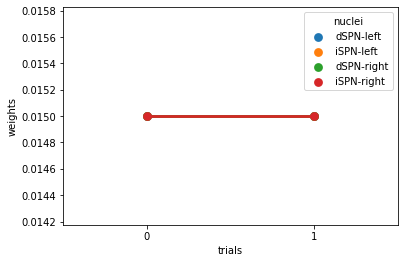

In [27]:
import seaborn as sns
import pylab as pl
sns.pointplot(x="trials",y="weights",hue="nuclei",data=recorded_variables['weight'])


<AxesSubplot:xlabel='Time(ms)', ylabel='value'>

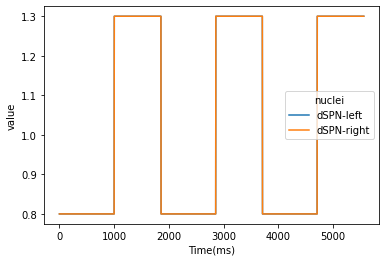

In [29]:
pl.figure()
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei')

In [30]:
# Relevant reward_dataframe
reward_q_df[0]

,level_0,index,Trials,variable,value,data_type,seed,n_trials,volatility,volatility_type,conflict,condition
0,0,4,0,left,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,1,5,1,left,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
2,2,6,2,left,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
3,3,7,3,left,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
4,4,8,0,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
5,5,9,1,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
6,6,10,2,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
7,7,11,3,right,0.500000,Q_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
8,0,0,0,left,0.000000,reward_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
9,1,1,1,left,0.998486,reward_df,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [31]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,66.666667,none,left,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,33.333333,none,right,8867366_0,3.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [32]:
# Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]["decisiondurationplusdelay"]-datatables[0]["decisionduration"]

0    254
1    252
2    252
dtype: object

In [33]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,none,0,1001,1001,1255,1255,left,0
1,none,1856,2857,1001,1253,3109,left,0
2,none,3710,4711,1001,1253,4963,right,0


In [34]:
# Check the Q-values data frame
results[0]['Q_df']

,left,right
0,0.5,0.5
0,0.5,0.5
0,0.5,0.5
0,0.5,0.5


In [35]:
# postfix = "weak_GPi_inh"
postfix = ""

In [36]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+postfix+'_'+str(seed)+'.pickle',['popfreqs','popdata','Q_support_params','d1','d2','dpmns','datatables'])


In [37]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
reward_q_df[0].to_csv(data_dir+"reward_df_"+postfix+".csv")
performance.to_csv(data_dir+"performance_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")
total_performance.to_csv(data_dir+"total_performance_"+postfix+".csv")

In [38]:
reward_q_df

[    level_0  index  Trials variable     value      data_type       seed  \
 0         0      4       0     left  0.500000           Q_df  8867366_0   
 1         1      5       1     left  0.500000           Q_df  8867366_0   
 2         2      6       2     left  0.500000           Q_df  8867366_0   
 3         3      7       3     left  0.500000           Q_df  8867366_0   
 4         4      8       0    right  0.500000           Q_df  8867366_0   
 5         5      9       1    right  0.500000           Q_df  8867366_0   
 6         6     10       2    right  0.500000           Q_df  8867366_0   
 7         7     11       3    right  0.500000           Q_df  8867366_0   
 8         0      0       0     left  0.000000      reward_df  8867366_0   
 9         1      1       1     left  0.998486      reward_df  8867366_0   
 10        2      2       2     left  0.000000      reward_df  8867366_0   
 11        3      3       0    right  0.000000      reward_df  8867366_0   
 12        4

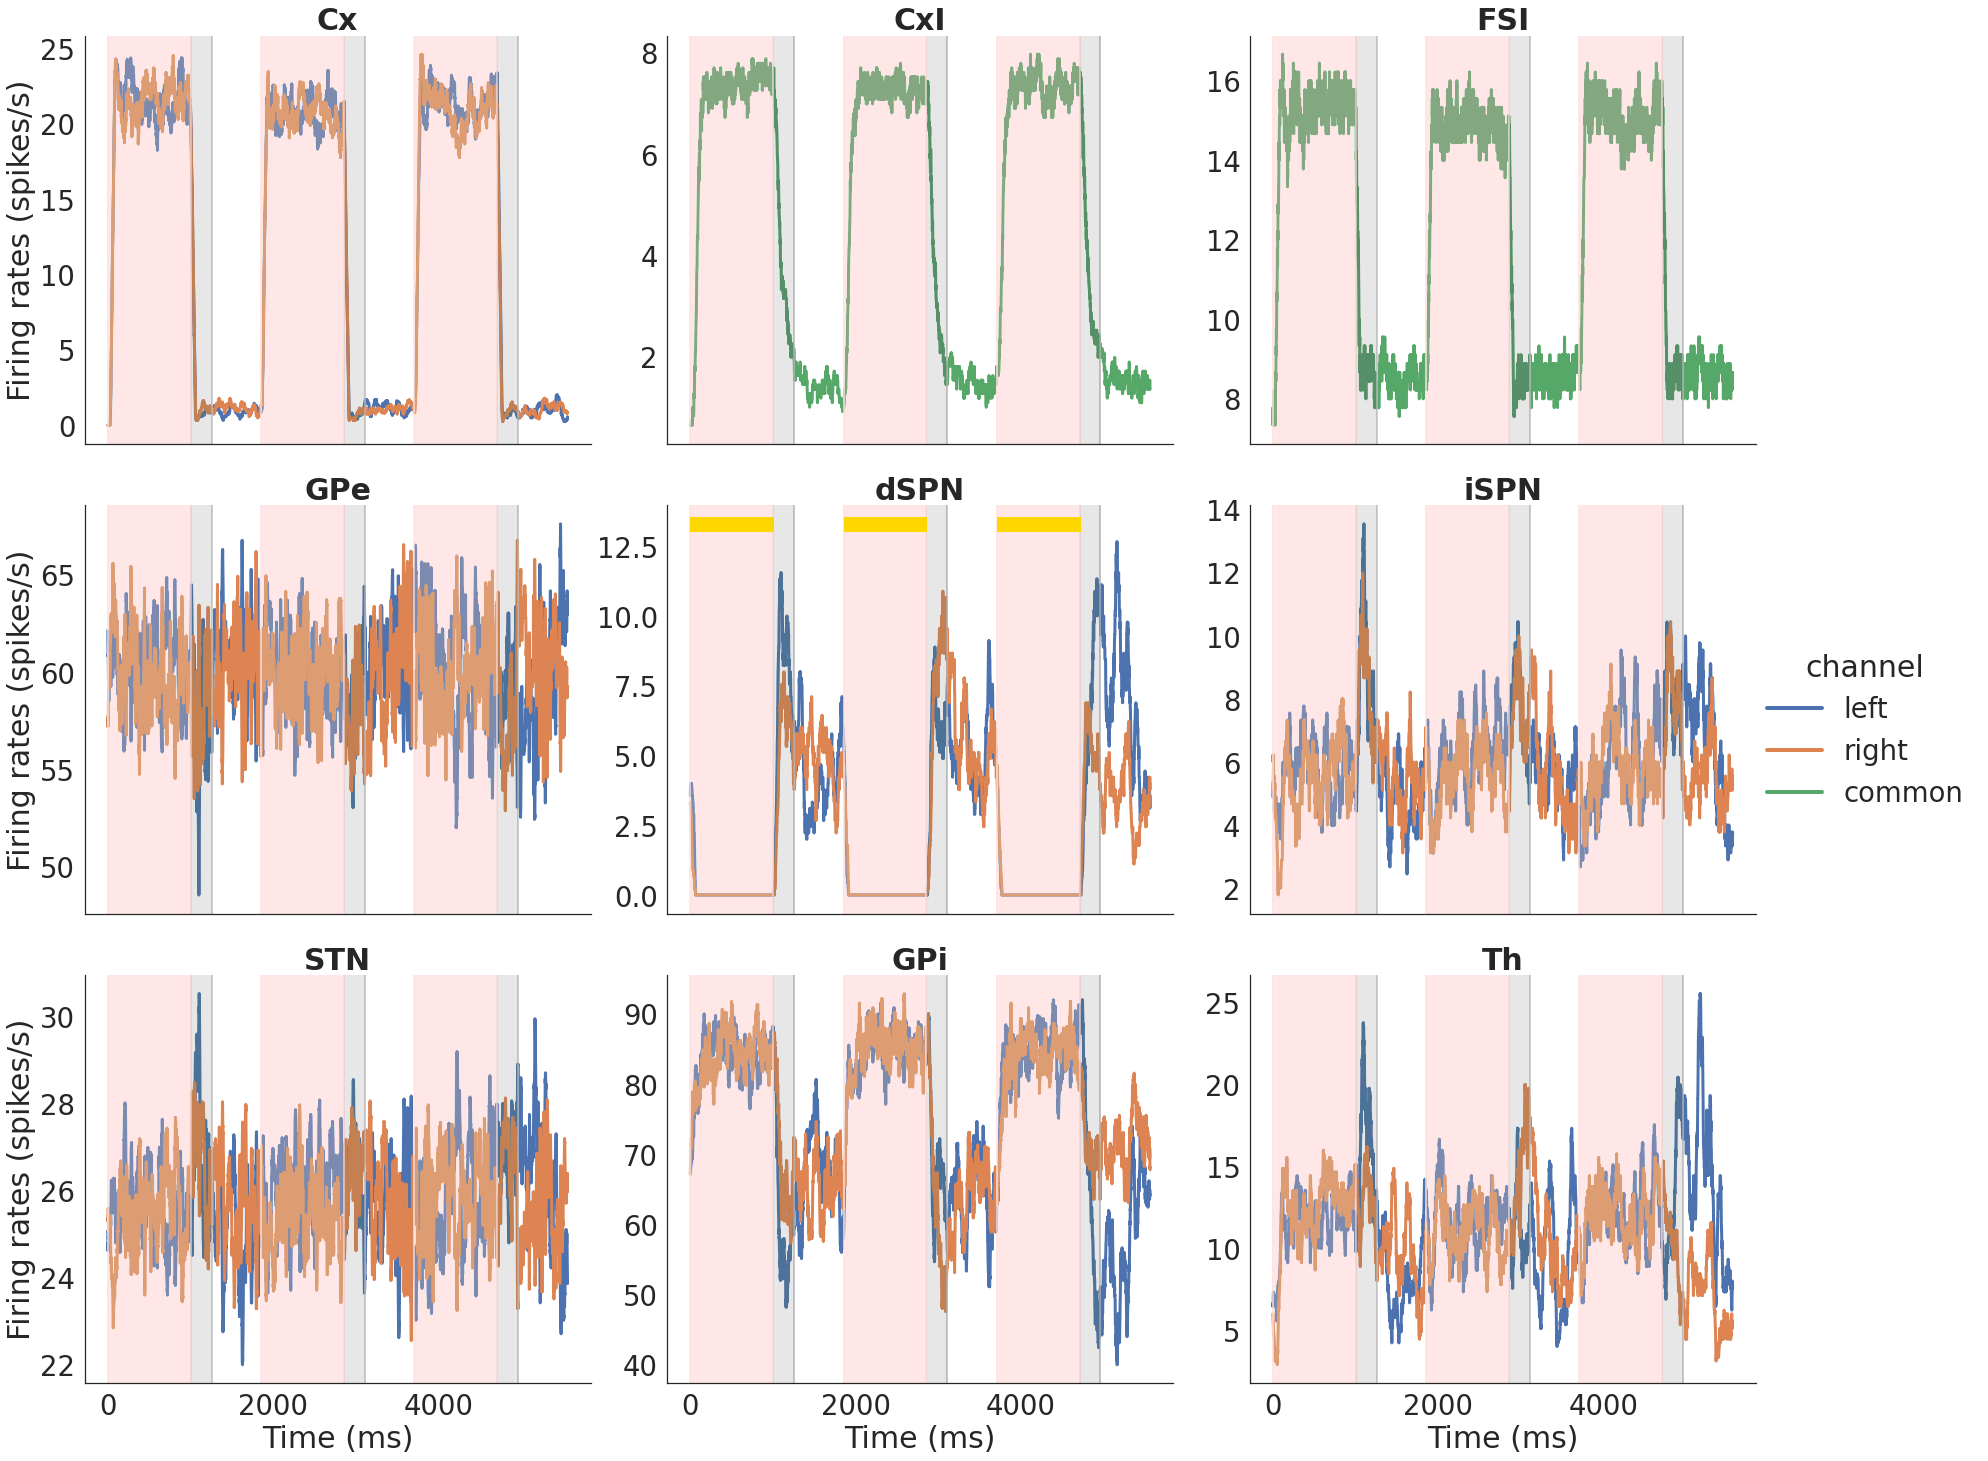

In [44]:
# Plot the firing rates extracted, figure handles are returned in fig_handles

FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_"+postfix+".png",dpi=400)

In [ ]:
# FR_fig_handles_zoom = plt_func.plot_fr_flex(firing_rates[0],datatables[0],['all'], [], (0, 500)) 

In [ ]:
reward_fig_handles = plt_func.plot_reward_Q_df(reward_q_df)